In [2]:
import torch
device = 'cuda:0'
#device = 'cuda:1'
device = device if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
!nvidia-smi

Mon Jun 24 13:31:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P6000                 WDDM  | 00000000:03:00.0  On |                 ERR! |
| 26%   39C    P8              15W / 250W |    260MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from tqdm import tqdm
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

from PIL import Image
import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as albu

from segmentation_models_pytorch import *

import numpy as np
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [5]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Ausgebaute Allwetterstrasse",
    "2": "Eisenbahn",
    "3": "Fußweg",
    "4": "Karawanenweg",
    "5": "Saumweg",
}
label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels: int = len(id2label)

In [6]:
import datasets
import glob
from sklearn.model_selection import train_test_split

root_path = "data/RoadSeg"
# Define file paths
train_IMAGES = sorted(glob.glob(root_path+"/Train/Image/*.tif"))
train_SEG_MAPS = sorted(glob.glob(root_path+"/Train/Mask/*.tif"))

val_IMAGES = sorted(glob.glob(root_path+"/Val/Image/*.tif"))
val_SEG_MAPS = sorted(glob.glob(root_path+"/Val/Mask/*.tif"))

test_IMAGES = sorted(glob.glob(root_path+"/Test/Image/*.tif"))
test_SEG_MAPS = sorted(glob.glob(root_path+"/Test/Mask/*.tif"))

# # Split the dataset
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     train_IMAGES + val_IMAGES, train_SEG_MAPS + val_SEG_MAPS, test_size=0.2, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )

# Create datasets
train_dataset_raw = datasets.Dataset.from_dict(
    {"image": train_IMAGES, "mask": train_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

val_dataset_raw = datasets.Dataset.from_dict(
    {"image": val_IMAGES, "mask": val_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

test_dataset_raw = datasets.Dataset.from_dict(
    {"image": test_IMAGES, "mask": test_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

# Print dataset information
print("Train Dataset:", train_dataset_raw)
print("Validation Dataset:", val_dataset_raw)
print("Test Dataset:", test_dataset_raw)


Train Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 4953
})
Validation Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 1415
})
Test Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 708
})


In [7]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, transform=None):
        self.images_fps = train_dataset[:]['image']
        self.masks_fps = train_dataset[:]['mask']
        self.transform = transform

    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, i):
        image = torch.tensor(np.array(self.images_fps[i].convert("RGB")))
        mask = torch.tensor(np.array(self.masks_fps[i]))
        if self.transform:
            transformed = self.transform(image=image.cpu().numpy(), mask=mask.cpu().numpy())
            image = torch.tensor(transformed['image']).to(device)
            mask = torch.tensor(transformed['mask']).to(device)


        image = torch.permute(image, (2, 0, 1))
        return {"pixel_values": image, "labels": mask}


In [8]:
def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.GaussNoise (p=0.2),
        #albu.Perspective(p=0.5),

        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)

In [9]:
train_dataset = CustomDataset(train_dataset=train_dataset_raw, transform=get_training_augmentation())

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
val_dataset = CustomDataset(train_dataset=val_dataset_raw, transform=None)

In [11]:
test_dataset = CustomDataset(train_dataset=test_dataset_raw, transform=None)

In [12]:
from sklearn.utils import compute_sample_weight
from pytorch_toolbelt.utils import fs
from torch.utils.data import WeightedRandomSampler

def get_balanced_weights(dataset):
    labels=[]
    for data in train_dataset:
      unique_labels = np.unique(data['labels'].cpu())
      labels.append(''.join([str(int(i)) for i in unique_labels]))

    weights = compute_sample_weight('balanced', labels)
    return weights

In [14]:
mul_factor =  5 #increases the total # of ims in a batch
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * mul_factor)
val_sampler = WeightedRandomSampler(get_balanced_weights(val_dataset), len(val_dataset) * mul_factor)

In [15]:
len(train_sampler.weights), len(val_sampler.weights)

(4953, 4953)

In [16]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=6,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

model = model.to(device)

model.device

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.linear_fuse.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias']
Y

device(type='cuda', index=0)

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def get_validation_scores(model, data_loader, loss_fn):
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  y_true = np.array([])
  y_pred = np.array([])
  loss_sum = 0

  model.eval()
  with torch.inference_mode():
    for batch in tqdm(data_loader):
      input_ids = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)

      inputs = processor(images=input_ids, return_tensors="pt").to(device)
    
      outputs = model(inputs["pixel_values"].to(device).float())

      downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss_sum += loss.item()

      preds = torch.argmax(outputs["logits"], dim=1)

      y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
      y_pred=np.append(y_pred, [preds.cpu().numpy()])

    include_label = [1,2,3,4,5]
    F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    acc = accuracy_score(y_true.flatten(), y_pred.flatten())

    f1 = np.asarray(F1)
    iou = np.asarray(IOU)
    prec = np.asarray(Precision)
    rec = np.asarray(Recall)

  return {
      "fscore": f1.mean(),
      "iou": iou.mean(),
      "precision": prec.mean(),
      "recall": rec.mean(),
      "accuracy": acc.mean(),
      "loss": loss_sum/len(data_loader)
  }

In [18]:
import datetime
def train(model, train_loader, val_loader, optim, loss_fn, num_epochs, valid_every, processor=None):
  best_fscore = 0.0
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
      optim.zero_grad()
      inputs = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)
      if processor != None:
        inputs = processor(images=inputs, return_tensors="pt")["pixel_values"]
      outputs = model(inputs.to(device).float())

      downsampled_labels  = max_pool(labels.float().unsqueeze(0)).squeeze()

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    epoch_loss = 0
    if epoch % valid_every == 0:
      results = get_validation_scores(model, val_loader, loss_fn)
      print(f"Validation: Loss: {results['loss']:.6f} | F1-Score: {results['fscore']*100:.2f}% | IoU: {results['iou']*100:.2f}% | Precision: {results['precision']*100:.2f}% | Recall: {results['recall']*100:.2f}% | Accuracy: {results['accuracy']*100:.2f}%")
      if results['fscore'] > best_fscore:
        best_fscore = results['fscore']
        torch.save(model, f"model-weighted-dice-newaug-adam-{datetime.date.today()}.pt")
        print(f"Model saved at {epoch+1} epoch")


In [19]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=16)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode='multiclass')
NUM_EPOCHS=300
VALID_EVERY=1

train(model=model,
      processor=processor,
      train_loader=train_loader,
      val_loader=val_loader,
      optim=optim,
      loss_fn=loss_fn,
      num_epochs=NUM_EPOCHS,
      valid_every=VALID_EVERY)

100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:49<00:00,  2.01s/it]


Epoch: 1, Loss: 0.37742801952038624


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.11it/s]


Validation: Loss: 0.226674 | F1-Score: 64.79% | IoU: 48.05% | Precision: 61.13% | Recall: 69.11% | Accuracy: 98.46%
Model saved at 1 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:20<00:00,  1.99s/it]


Epoch: 2, Loss: 0.2149734568206993


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.221561 | F1-Score: 65.64% | IoU: 48.96% | Precision: 62.37% | Recall: 69.36% | Accuracy: 98.55%
Model saved at 2 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:32<00:00,  2.00s/it]


Epoch: 3, Loss: 0.18130585645116115


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.213471 | F1-Score: 66.66% | IoU: 50.06% | Precision: 63.88% | Recall: 69.85% | Accuracy: 98.55%
Model saved at 3 epoch


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:29<00:00,  2.00s/it]


Epoch: 4, Loss: 0.15708525630450526


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.213680 | F1-Score: 66.55% | IoU: 49.94% | Precision: 64.67% | Recall: 68.64% | Accuracy: 98.57%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:32<00:00,  2.00s/it]


Epoch: 5, Loss: 0.13813344495087015


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.10it/s]


Validation: Loss: 0.215946 | F1-Score: 66.38% | IoU: 49.74% | Precision: 66.27% | Recall: 66.67% | Accuracy: 98.62%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:27<00:00,  1.99s/it]


Epoch: 6, Loss: 0.12523423724396285


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]


Validation: Loss: 0.214391 | F1-Score: 66.24% | IoU: 49.60% | Precision: 64.73% | Recall: 67.96% | Accuracy: 98.59%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:29<00:00,  2.00s/it]


Epoch: 7, Loss: 0.11741099118926497


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.11it/s]


Validation: Loss: 0.216682 | F1-Score: 66.05% | IoU: 49.38% | Precision: 65.18% | Recall: 67.00% | Accuracy: 98.59%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:29<00:00,  2.00s/it]


Epoch: 8, Loss: 0.10918695125151281


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.215360 | F1-Score: 66.26% | IoU: 49.61% | Precision: 65.53% | Recall: 67.12% | Accuracy: 98.61%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:34<00:00,  2.00s/it]


Epoch: 9, Loss: 0.10371859850077975


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.217576 | F1-Score: 65.90% | IoU: 49.23% | Precision: 65.50% | Recall: 66.35% | Accuracy: 98.61%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:48<00:00,  2.01s/it]


Epoch: 10, Loss: 0.0991427982466666


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]


Validation: Loss: 0.217859 | F1-Score: 65.78% | IoU: 49.10% | Precision: 66.13% | Recall: 65.51% | Accuracy: 98.62%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:39<00:00,  2.00s/it]


Epoch: 11, Loss: 0.09403241197374054


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.222080 | F1-Score: 65.31% | IoU: 48.60% | Precision: 66.20% | Recall: 64.48% | Accuracy: 98.63%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:56<00:00,  2.01s/it]


Epoch: 12, Loss: 0.08940627016800935


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:21<00:00,  1.09it/s]


Validation: Loss: 0.221111 | F1-Score: 65.42% | IoU: 48.70% | Precision: 65.96% | Recall: 64.96% | Accuracy: 98.61%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:45<00:00,  2.01s/it]


Epoch: 13, Loss: 0.08595479981256625


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]


Validation: Loss: 0.218879 | F1-Score: 65.94% | IoU: 49.26% | Precision: 66.37% | Recall: 65.54% | Accuracy: 98.63%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:43<00:00,  2.00s/it]


Epoch: 14, Loss: 0.0832743105437674


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.220034 | F1-Score: 65.49% | IoU: 48.79% | Precision: 66.72% | Recall: 64.33% | Accuracy: 98.65%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:49<00:00,  2.01s/it]


Epoch: 15, Loss: 0.08179620072698024


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.220138 | F1-Score: 65.64% | IoU: 48.93% | Precision: 66.69% | Recall: 64.68% | Accuracy: 98.64%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:38<00:00,  2.00s/it]


Epoch: 16, Loss: 0.07931421958246973


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:21<00:00,  1.10it/s]


Validation: Loss: 0.221805 | F1-Score: 65.73% | IoU: 49.02% | Precision: 66.44% | Recall: 65.12% | Accuracy: 98.60%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:51<00:00,  2.01s/it]


Epoch: 17, Loss: 0.07592845696580502


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.10it/s]


Validation: Loss: 0.223213 | F1-Score: 65.38% | IoU: 48.67% | Precision: 67.99% | Recall: 63.05% | Accuracy: 98.65%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:35<00:00,  2.00s/it]


Epoch: 18, Loss: 0.07504880616263286


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:21<00:00,  1.09it/s]


Validation: Loss: 0.220342 | F1-Score: 65.68% | IoU: 48.99% | Precision: 66.87% | Recall: 64.69% | Accuracy: 98.61%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:31<00:00,  2.00s/it]


Epoch: 19, Loss: 0.0733270850826719


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.221250 | F1-Score: 65.60% | IoU: 48.87% | Precision: 66.99% | Recall: 64.29% | Accuracy: 98.64%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:32<00:00,  2.00s/it]


Epoch: 20, Loss: 0.07224037174198016


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:21<00:00,  1.09it/s]


Validation: Loss: 0.222451 | F1-Score: 65.49% | IoU: 48.79% | Precision: 67.07% | Recall: 64.01% | Accuracy: 98.66%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:47<00:00,  2.01s/it]


Epoch: 21, Loss: 0.07006763272199212


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]


Validation: Loss: 0.218741 | F1-Score: 65.88% | IoU: 49.21% | Precision: 67.25% | Recall: 64.59% | Accuracy: 98.66%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:39<00:00,  2.00s/it]


Epoch: 22, Loss: 0.06823934031799628


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.10it/s]


Validation: Loss: 0.221973 | F1-Score: 65.54% | IoU: 48.83% | Precision: 67.48% | Recall: 63.76% | Accuracy: 98.65%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:45<00:00,  2.01s/it]


Epoch: 23, Loss: 0.06652446018016923


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.222286 | F1-Score: 65.55% | IoU: 48.84% | Precision: 66.83% | Recall: 64.37% | Accuracy: 98.65%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:42<00:00,  2.00s/it]


Epoch: 24, Loss: 0.06618892995265219


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.219924 | F1-Score: 65.60% | IoU: 48.90% | Precision: 67.35% | Recall: 64.06% | Accuracy: 98.63%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:28<00:00,  2.00s/it]


Epoch: 25, Loss: 0.06536141405777299


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.221241 | F1-Score: 65.63% | IoU: 48.92% | Precision: 68.02% | Recall: 63.43% | Accuracy: 98.66%


100%|██████████████████████████████████████████████████████████████████████████████| 1548/1548 [51:27<00:00,  1.99s/it]


Epoch: 26, Loss: 0.06597334439372908


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.223882 | F1-Score: 65.01% | IoU: 48.25% | Precision: 68.83% | Recall: 61.61% | Accuracy: 98.68%


 10%|███████▉                                                                       | 156/1548 [05:14<46:48,  2.02s/it]


KeyboardInterrupt: 

In [20]:
best_model = torch.load('model-weighted-dice-newaug-adam-2024-06-24.pt')
best_model = best_model.to(device)

In [21]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

y_true = np.array([])
y_pred = np.array([])

model.eval()
for batch in tqdm(test_loader):
    input_ids = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    inputs = processor(images=input_ids, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = best_model(inputs["pixel_values"].to(device).float())

    downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

    preds = torch.argmax(outputs["logits"], dim=1)
    y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
    y_pred=np.append(y_pred, [preds.cpu().numpy()])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:38<00:00,  1.16it/s]


In [22]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

include_label = [1,2,3,4,5]
F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
acc = accuracy_score(y_true.flatten(), y_pred.flatten())

f1 = np.asarray(F1)
iou = np.asarray(IOU)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, iou, prec, rec), axis = 1)
df = pd.DataFrame(metrics, columns= ['F1-Score', 'IoU', 'Precision', 'Recall'])
df.index += 1
df

,F1-Score,IoU,Precision,Recall
1,0.691085,0.527983,0.660800,0.724279
2,0.676581,0.511237,0.622712,0.740653
3,0.685663,0.521680,0.675764,0.695856
4,0.717202,0.559092,0.694281,0.741689
5,0.578004,0.406474,0.492787,0.698857


In [23]:
print(f"F1-Score: {f1.mean()*100:.2f}%")
print(f"IoU: {iou.mean()*100:.2f}%")
print(f"Precision: {prec.mean()*100:.2f}%")
print(f"Recall: {rec.mean()*100:.2f}%")
print(f"Overall Accuracy: {acc*100:.2f}%")

F1-Score: 66.97%
IoU: 50.53%
Precision: 62.93%
Recall: 72.03%
Overall Accuracy: 98.57%


In [24]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


<Axes: xlabel='Predicted label', ylabel='True label'>

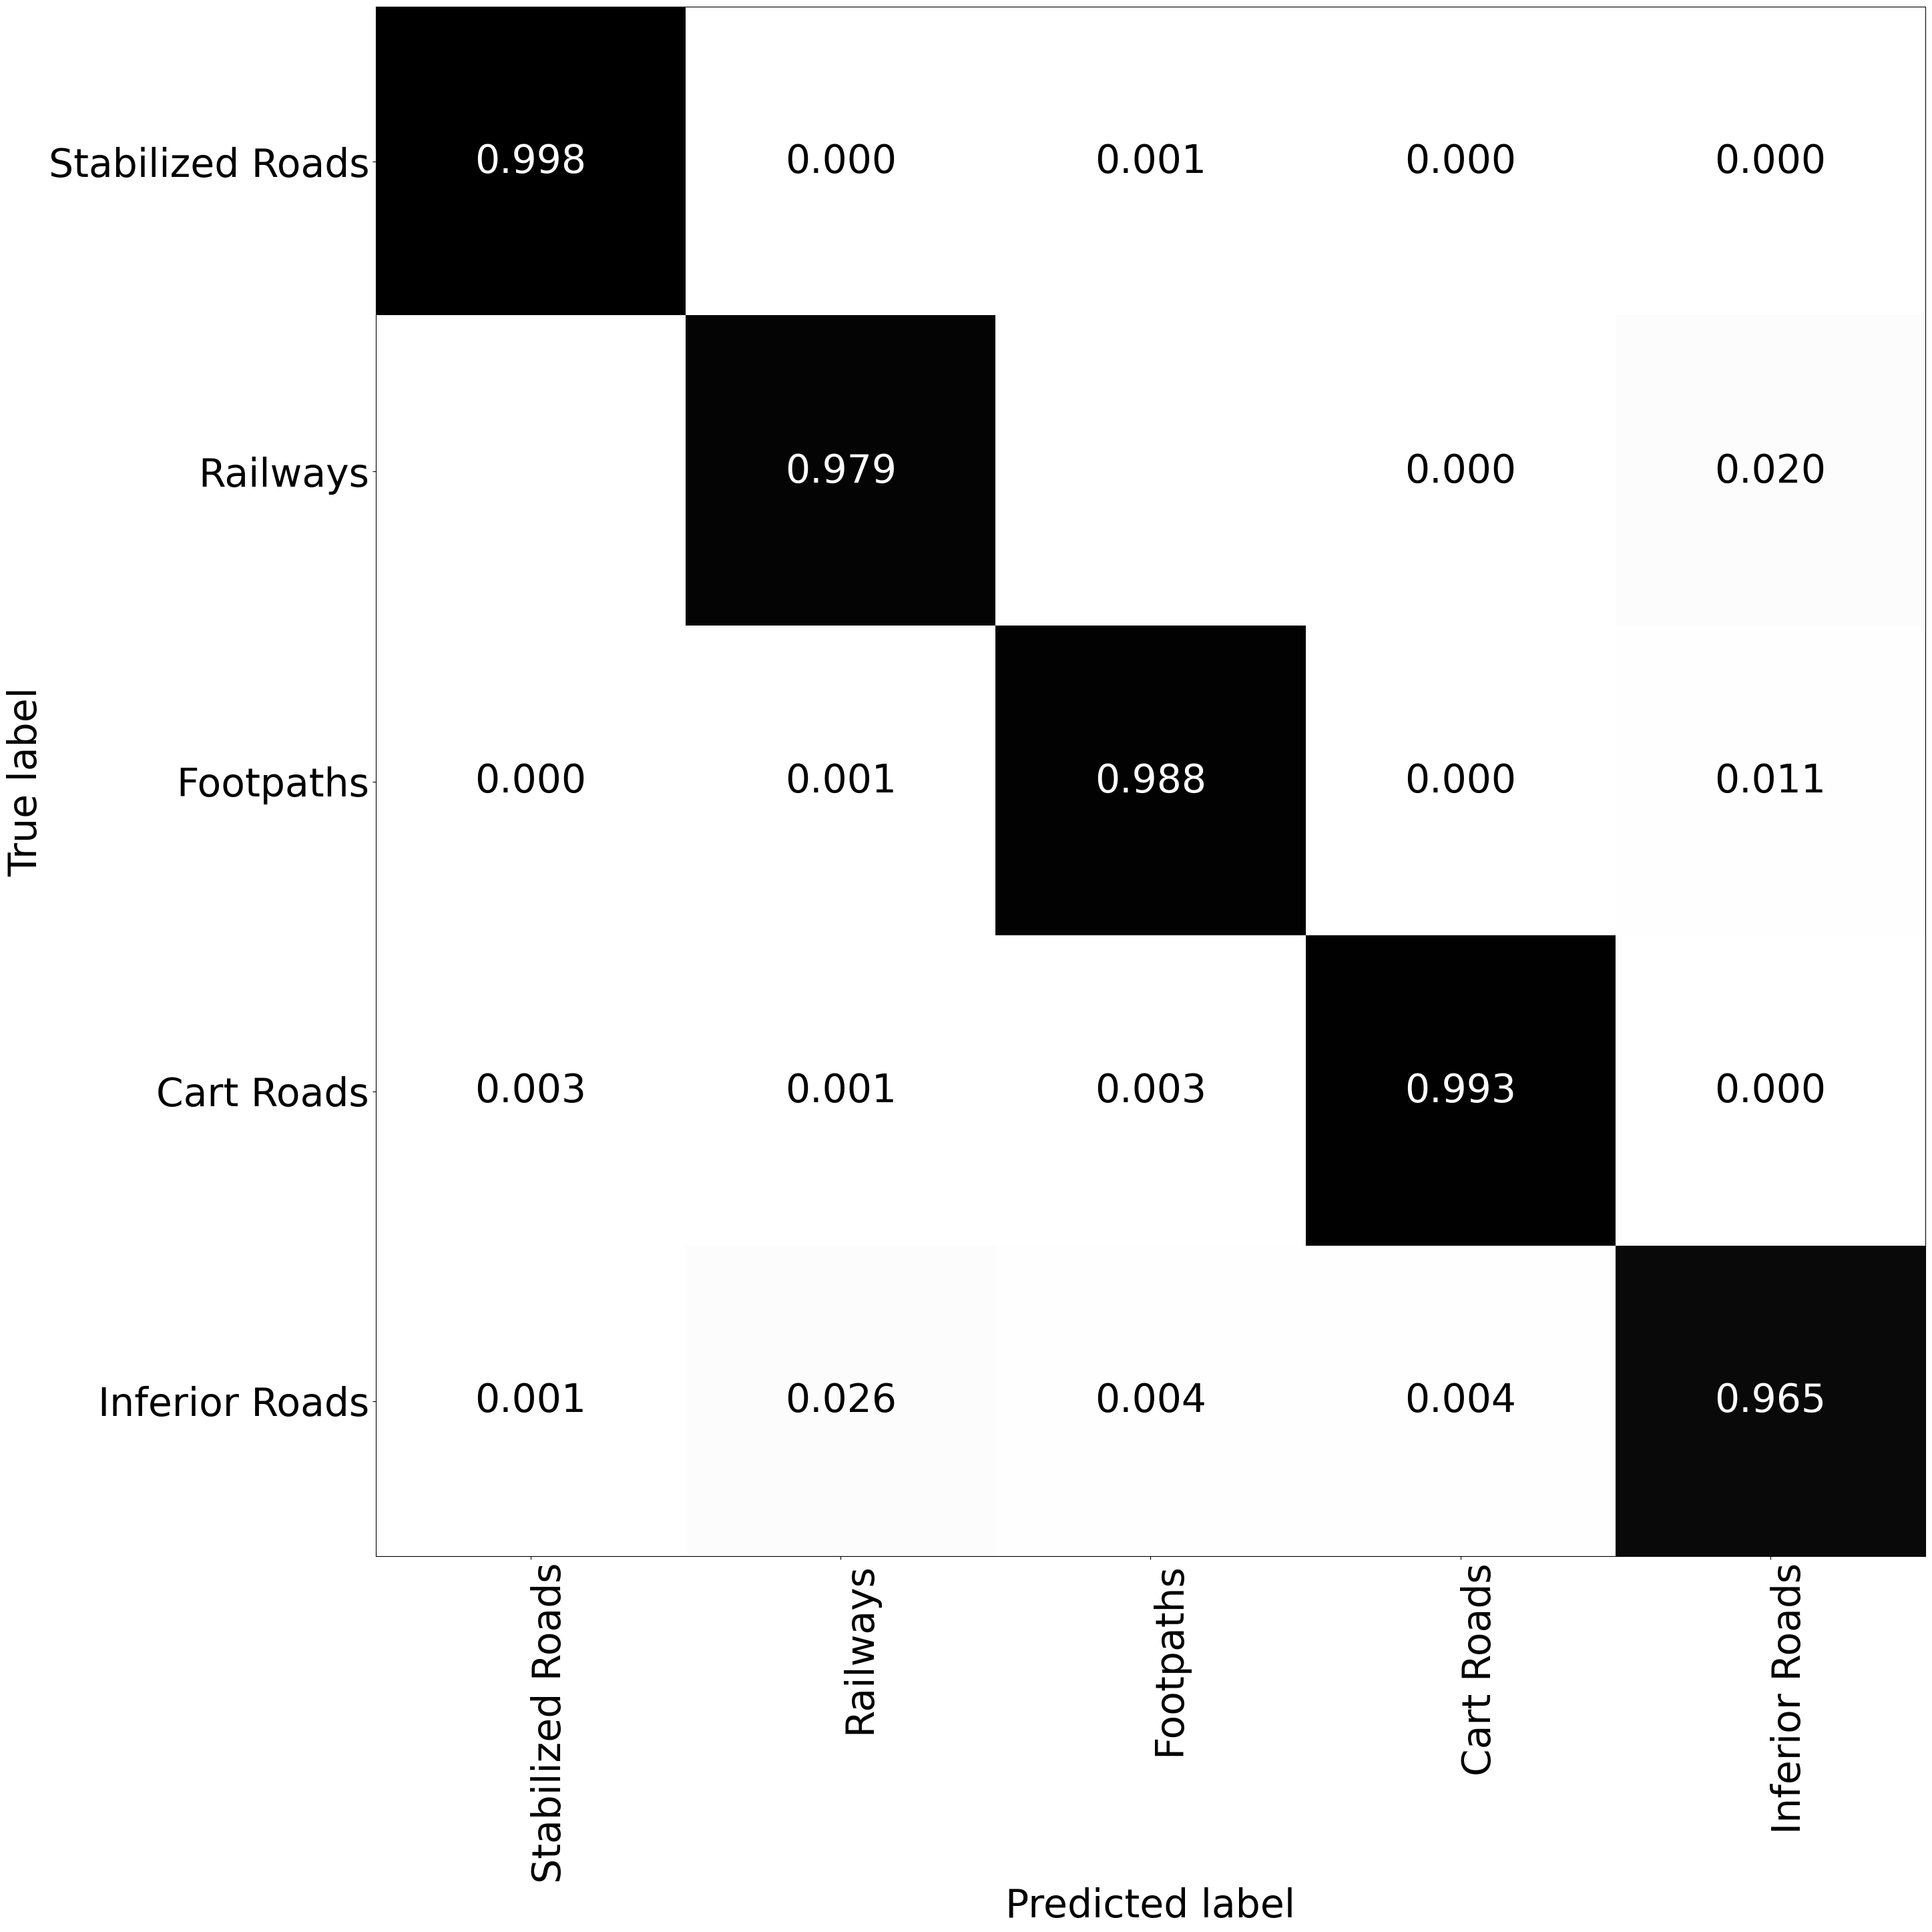

In [26]:
plot_confusion_matrix(ys=y_true,
                      y_preds=y_pred,
                      classes=ing_Class_names,
                      normalize=True)

In [39]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


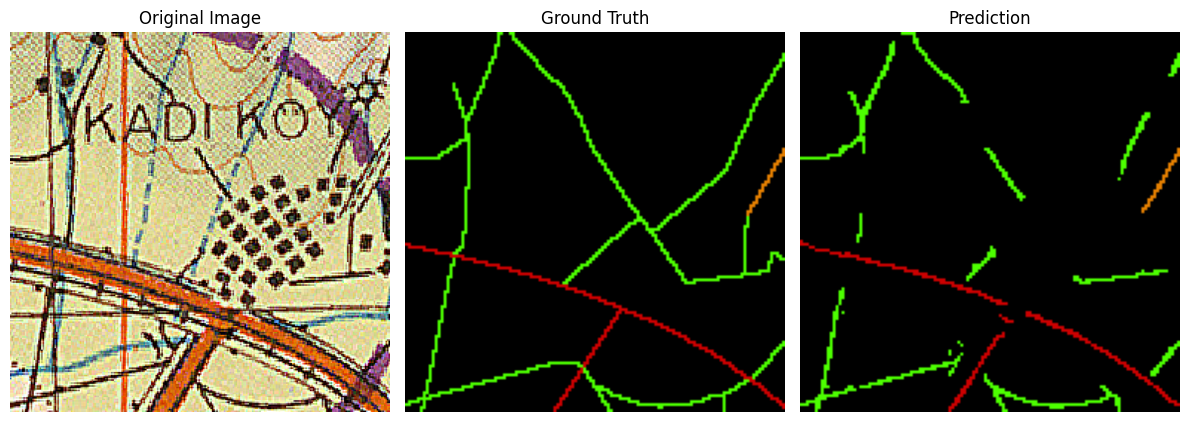

In [40]:
import matplotlib

# Reset to default parameters
matplotlib.rcdefaults()

ds = train_dataset
a = ds[np.random.randint(len(ds))]
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

model.eval()
with torch.inference_mode():
    inputs = a["pixel_values"].to(device).float()
    processed_inputs = processor(images=inputs, return_tensors="pt").to(device)
    out = best_model(pixel_values=processed_inputs["pixel_values"])
    segmented_image = convert_to_color(out["logits"].argmax(dim=1).cpu().squeeze())

    downsampled_labels = max_pool(a["labels"].float().unsqueeze(0).unsqueeze(0))

    colored_logits = convert_to_color(downsampled_labels.squeeze().cpu())
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image on the left side
    axs[0].imshow(a["pixel_values"].permute(1, 2, 0).cpu().numpy())  # Assuming shape is CxHxW
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the segmented image on the right side
    axs[1].imshow(colored_logits)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    # Display the segmented image on the right side
    axs[2].imshow(segmented_image)
    axs[2].set_title('Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
